# Hydrogel-Cell Interaction

In this case, we only have the deformed shape of the spherical hydrogel as shown in the next few cells.

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as spm
from scipy.io import loadmat, savemat

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import sys, time, os.path
from itertools import permutations

module_path = '../module/'
sys.path.append(module_path)
from SHUtil import SphCoord_to_CartCoord, CartCoord_to_SphCoord

import pyshtools
from SHUtil import SHCilmToVector, SHVectorToCilm, lmk2K, K2lmk
from SHUtil import plotfv, TransMat, l_coeffs, m_coeffs, LM_list
from ShElastic import calSmode, calUmode
from SHBV import generate_submat, visualize_Cmat, print_SH_mode

from scipy.sparse.linalg import lsqr, spsolve
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import minimize

from Case05_utilities import d2v, d2e, d2f
from Case05_utilities import Uvec2Tvec, Tvec2Uvec
from Case05_utilities import SHVec2mesh, visSHVec, visSH3d
from Case05_utilities import SHvec_rtoc, SHvec_ctor
from Case05_utilities import generate_fcache, generate_Xneigh, generate_Eneigh, generate_Fneigh

In [2]:
############################# change inputs here #################################
# Data file name
datadir = '../testdata'
smoothed = 'smoothed'; smoothed = '';
dilated = '_1um_dilated'; #dilated = '';
shapename = 'Shape2'
datafile = os.path.join(datadir, shapename+'_Coordinates_Cart_'+smoothed+'.csv')
connfile = os.path.join(datadir, shapename+'_Connectivity.csv')
maskfile = os.path.join(datadir, shapename+'_Mask'+dilated+'.csv')

# Material properties
mu0 = 300/3;
mu = 1.; nu = 0.499;

# Spherical Harmonics Analysis Settings
lJmax = 30; lKmax = 30; lmax_plot = 60;
lmax_work = np.int(0.8*lKmax); lmax_buf = lJmax-lmax_work;

# target function settings
myalpha = 0.025
mybeta = 0.025

# dump files for minimization
savename = shapename+('_lmax%d'%lJmax)+smoothed+dilated
directory = ''#'../runs/Case05_Shape2'
n_runs = ''
AKfile = 'AK_iter_'+savename+'.npy'
fvfile = 'fv_'+savename+'.txt'
AK_sol = np.load(AKfile)

# Spherical Harmonics Analysis Settings
lKmax = np.int(np.sqrt(AK_sol.size/3) - 1)
lJmax = lKmax;

# settings for loading \hat{U}, \hat{T} coefficients
shtype = 'reg'
coeff_dir = os.path.join(module_path, 'lmax%dmodes'%60)
#################################################################################

Umodes = loadmat(os.path.join(coeff_dir,'Umodes.mat'))
Umodes = (Umodes['U1'+shtype], Umodes['U0'+shtype])
fullDmat = calUmode(Umodes, mu, nu)
Dmat = generate_submat(mu, nu, fullDmat, lKmax, lJmax, kJ=3).tocsc()

Tmodes = loadmat(os.path.join(coeff_dir,'Tmodes.mat'))
Tmodes = (Tmodes['T1'+shtype], Tmodes['T2'+shtype], Tmodes['T3'+shtype], Tmodes['T0'+shtype])
fullCmat = calSmode(Tmodes, mu, nu)
Cmat = generate_submat(mu, nu, fullCmat, lKmax, lJmax, kJ=3).tocsc()

data, connectivity: (8136, 3) (16268, 3)
id of nodes, edges, facets: (8136,) (24402, 2) (16268, 3)
coord of nodes, edges, facets: (8136, 3) (24402, 2, 3) (16268, 3, 3)
Traction free boundary of v, e, f: (8136,) (24402,) (16268,)


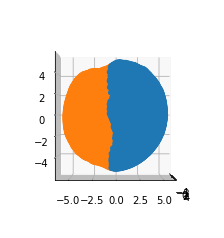

In [3]:
#### load the geometry ####
# Vs, Vp: list of nodes (nV, trivial), coordinates of the nodes (nVx3)
# Es, Ep: list of edges (nEx2), list of points on the edges (nEx2x3)
# Fs, Fp: list of facets (nFx3), list of points on the facets (nFx3x3)
# Tfv: traction free boundary map of the node list
# Tfe: traction free boundary map of the edge list
# Tff: traction free boundary map of the face list
# Tf_diluted: diluted traction free boundary map

data = np.genfromtxt(datafile, delimiter=',')
conn = np.genfromtxt(connfile, delimiter=',', dtype=np.int)
if shapename == 'Shape4':
    mask = np.zeros_like(data[:,0]).astype(np.int)
else:
    mask = np.genfromtxt(maskfile, dtype=np.int)
print('data, connectivity:', data.shape, conn.shape)

Fs = conn - 1
Np = data.shape[0]
Vs = np.arange(Np)
edge_conn = spm.lil_matrix((Np, Np), dtype=bool)
for i, j in permutations(range(3), 2):
    edge_conn[Fs[:, i], Fs[:, j]] = True
Es = spm.triu(edge_conn).tocoo()
Es = np.vstack([Es.row, Es.col]).T
print('id of nodes, edges, facets:', Vs.shape, Es.shape, Fs.shape)
Vp = data[..., :3]
Ep = Vp[Es, :]; Fp = Vp[Fs, :];
print('coord of nodes, edges, facets:', Vp.shape, Ep.shape, Fp.shape)

#Tf_diluted = data[:, 4].astype(np.bool)
#Tfv = np.logical_not(data[:, 3].astype(np.bool))
Tfv = mask.astype(np.bool) # np.logical_not(mask.astype(np.bool))
Tfe = np.all(Tfv[Es], axis=1)
Tff = np.all(Tfv[Fs], axis=1)
print('Traction free boundary of v, e, f:', Tfv.shape, Tfe.shape, Tff.shape)

#### Plot the geometry (Vp) ####
fig = plt.figure()#figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2])
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2])

eTf = Line3DCollection(np.hstack([Ep[Tfe, 0, :], Ep[Tfe, 1, :]]).copy().reshape((-1,2,3)), colors='C0')
ax.add_collection(eTf)
nTfe = np.logical_not(Tfe)
eTf = Line3DCollection(np.hstack([Ep[nTfe, 0, :], Ep[nTfe, 1, :]]).copy().reshape((-1,2,3)), colors='C1')
ax.add_collection(eTf)

ax.view_init(azim=0, elev=0)

ax.set_aspect('equal')
plt.show()

Then we determine the original radius of the particle, assuming the particle is incompressible. The total volume can be estimated by adding the volume of the tetrahedrons. The volume of a tetrahedron is calculated as:

$$
V_{0123}=\frac{1}{6}
\begin{vmatrix}
 x_1 & y_1 & z_1 & 1\\ 
 x_2 & y_2 & z_2 & 1\\ 
 x_3 & y_3 & z_3 & 1\\ 
 0 & 0 & 0 & 1\\ 
\end{vmatrix}
$$

In [4]:
tet = np.zeros((Fs.shape[0], 4, 4))
tet[:,:-1,:-1] = Fp
tet[:,:,-1] = 1
vol = np.sum(np.linalg.det(tet)/6, axis=0)
r0 = np.cbrt(vol/(4/3*np.pi))
print('V = %.4f, r0 = %.4f'%(vol, r0))

V = 607.3097, r0 = 5.2534


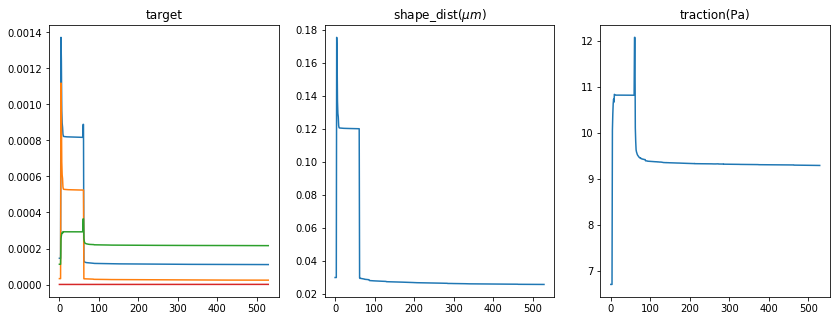

[1.107921e-04 2.588343e-02 9.292451e+00 2.427520e-05 8.634965e-03
 3.345287e-05]


In [5]:
plot_funval = np.loadtxt(fvfile)[270:, 1:]
plt.figure(figsize=(14,5))
plt.subplot(131)
plt.plot(plot_funval[:, 0])
if plot_funval.shape[1] > 5:
    plt.plot(plot_funval[:, 3])
    plt.plot(plot_funval[:, 4]*myalpha)
    plt.plot(plot_funval[:, 5]*mybeta)
plt.title('target')
plt.subplot(132)
plt.plot(plot_funval[:, 1])
plt.title('shape_dist$(\mu m)$')
plt.subplot(133)
plt.plot(plot_funval[:, 2])
plt.title('traction(Pa)')
plt.savefig(savename+'_convergence.png', transparent=True)
plt.show()
print(plot_funval[-1,:])

Plot the Solution Vector


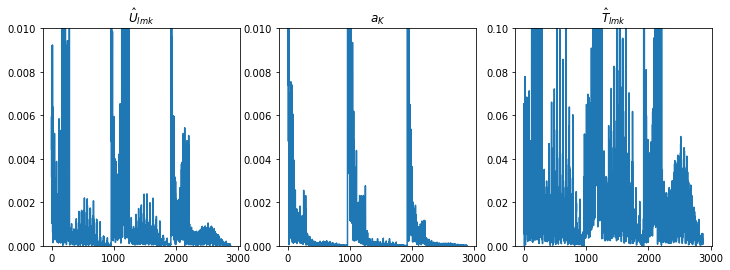

In [6]:
# Load the solution file

Uvec1 = Dmat.dot(AK_sol); Tvec1 = Cmat.dot(AK_sol)

print('Plot the Solution Vector')
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(np.abs(Uvec1)); plt.ylim(0, 0.01); plt.title('$\hat{U}_{lmk}$')
plt.subplot(132)
plt.plot(np.abs(AK_sol)); plt.ylim(0, 0.01); plt.title('$a_K$')
plt.subplot(133)
plt.plot(np.abs(Tvec1)); plt.ylim(0, 0.1); plt.title('$\hat{T}_{lmk}$')
plt.savefig(savename+'_coeffs.png', transparent=True)
plt.show()

Plot displacement map


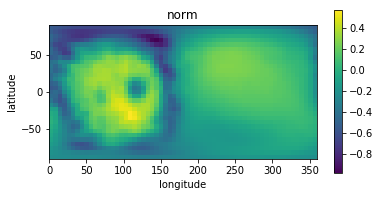

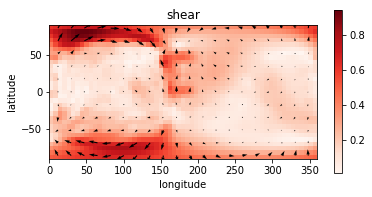

Plot traction map


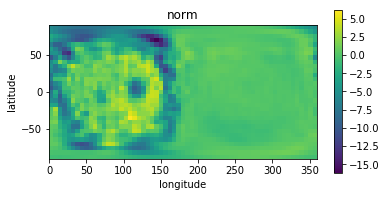

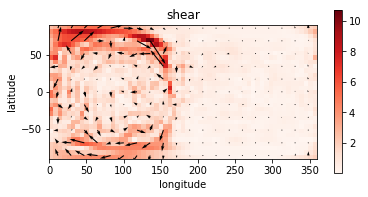

Evaluate Displacement and Traction in Cartesian Coordinates...


In [7]:
print('Plot displacement map')
fig, ax = visSHVec(Uvec1*r0, lmax_plot=lJmax,
                   SphCoord=True, Complex=True,     # spherical coord switch, complex coefficient switch
                   # n_vrange=(-1,1), s_vrange=(0,0.01), # normal and shear map value range
                   config_quiver=(2, 3, 'k', 20),   # setting of quiver in shear map
                   lonshift=180,                    # shift the map in longitude direction
                   figsize=(6,3), show=False)       # figure size
fig[0].savefig(savename+'_un.png', transparent=False)
fig[1].savefig(savename+'_us.png', transparent=False)
plt.show()
print('Plot traction map')
fig, ax = visSHVec(Tvec1*r0, lmax_plot=lJmax, 
                   SphCoord=True, Complex=True,     # spherical coord switch, complex coefficient switch
                   # n_vrange=(-200, 200), s_vrange=(0,0.01), # normal and shear map value range
                   config_quiver=(2, 3, 'k', 100), # setting of quiver in shear map
                   lonshift=180,                    # shift the map in longitude direction
                   figsize=(6,3), show=False)       # figure size
fig[0].savefig(savename+'_Tn.png', transparent=False)
fig[1].savefig(savename+'_Ts.png', transparent=False)
plt.show()

print('Evaluate Displacement and Traction in Cartesian Coordinates...')
umesh1 = SHVec2mesh(Uvec1, lmax=lJmax, SphCoord=False, Complex=True)
tmesh1 = SHVec2mesh(Tvec1*mu0, lmax=lJmax, SphCoord=False, Complex=True)
umesh1_fine = SHVec2mesh(Uvec1, lmax=lmax_plot, SphCoord=False, Complex=True)
tmesh1_fine = SHVec2mesh(Tvec1*mu0, lmax=lmax_plot, SphCoord=False, Complex=True)

0.05397267280191636


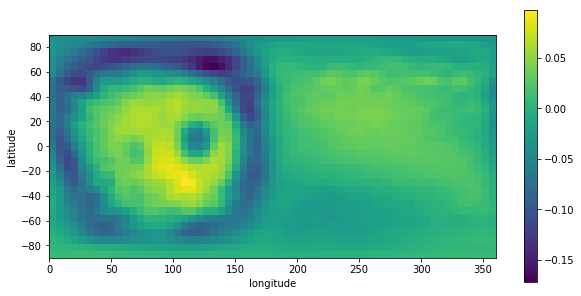

In [8]:
# Vp -> ur (radial displacement) -> u1 (x,y,z)
Vr, Vthe, Vphi = CartCoord_to_SphCoord(Vp[...,0], Vp[...,1], Vp[...,2])
Vphi[Vphi < 0] += 2*np.pi
Vlat = 90-np.rad2deg(Vthe)
Vlon = np.rad2deg(Vphi)
ur = (Vr - r0)/r0

urcilm_interp, chi2 = pyshtools.expand.SHExpandLSQ(ur, Vlat, Vlon, lmax=lJmax)
print(chi2)

ucoeff_interp = pyshtools.SHCoeffs.from_array(urcilm_interp)
urgrid_interp = ucoeff_interp.expand('GLQ')
fig, ax = plotfv(urgrid_interp.to_array(), lonshift=180)

0.035114411925279775


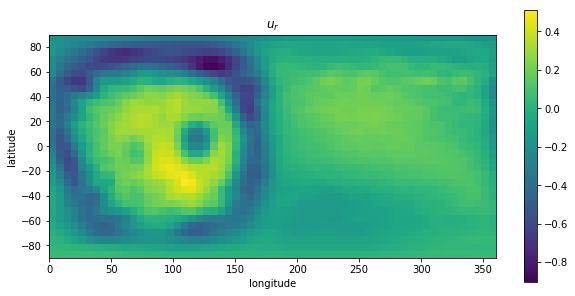

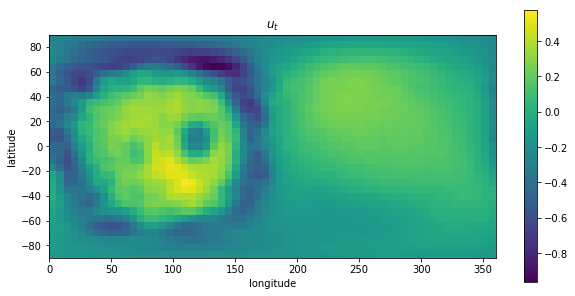

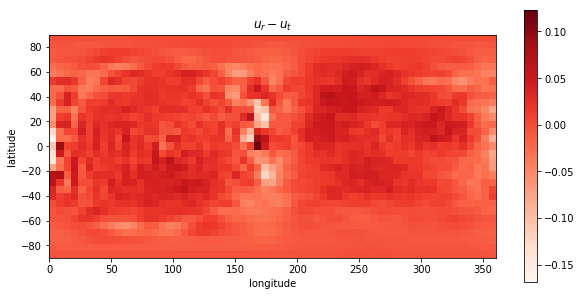

squared dist(unit sphere): 2.0647531198565895e-05
difference(um): 0.023871219288106007


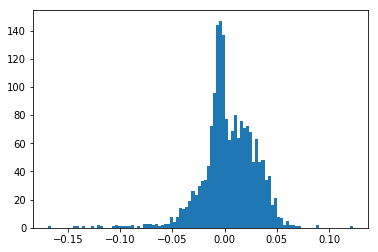

In [17]:
latsdeg, lonsdeg = pyshtools.expand.GLQGridCoord(lmax_plot)
lon = np.deg2rad(lonsdeg)
colat = np.deg2rad(90-latsdeg)
PHI, THETA = np.meshgrid(lon, colat)
R = np.ones_like(PHI)
X,Y,Z = SphCoord_to_CartCoord(R, THETA, PHI)
X0 = np.stack([X,Y,Z], axis=-1)
Xt = X0 + SHVec2mesh(Uvec1, lmax=lmax_plot, SphCoord=False, Complex=True)

rt, thet, phit = CartCoord_to_SphCoord(Xt[...,0], Xt[...,1], Xt[...,2])
phit[phit < 0] += 2*np.pi
latt = 90-np.rad2deg(thet)
lont = np.rad2deg(phit)
urt = rt - 1

rtcilm_interp, chi2 = pyshtools.expand.SHExpandLSQ(urt.flatten(), latt.flatten(), lont.flatten(), lmax=lJmax)
print(chi2)

utcoeff_interp = pyshtools.SHCoeffs.from_array(rtcilm_interp)
utgrid_interp = utcoeff_interp.expand('GLQ')
fig, ax = plotfv(urgrid_interp.to_array()*r0, lonshift=180, show=False)
ax.set_title('$u_r$'); fig.savefig(savename+'_ur.png', transparent=True)
fig, ax = plotfv(utgrid_interp.to_array()*r0, lonshift=180, show=False)
ax.set_title('$u_t$'); fig.savefig(savename+'_ut.png', transparent=True)

udgrid_interp = urgrid_interp.copy()
TT = np.deg2rad(90 - udgrid_interp.lats())
PP = np.deg2rad(udgrid_interp.lons())
ud_tmp = utgrid_interp.to_array() - urgrid_interp.to_array()
udz_tmp = ud_tmp * np.cos(TT[:,np.newaxis])
ud_new = np.sqrt(ud_tmp**2 - udz_tmp**2 + (udz_tmp/3)**2)
udgrid_interp.data = np.sign(ud_tmp) * ud_new * np.sin(TT[:,np.newaxis])
fig, ax = plotfv(udgrid_interp.to_array()*r0, lonshift=180, show=False, cmap='Reds')
ax.set_title('$u_r-u_t$'); fig.savefig(savename+'_ud.png', transparent=True)
plt.show()

dist_ud = np.mean((udgrid_interp.data**2)*np.sin(TT[:,np.newaxis]))
print('squared dist(unit sphere):', dist_ud)
print('difference(um):', np.sqrt(dist_ud)*r0)
plt.hist(udgrid_interp.data.flatten()*r0, bins=100)
plt.savefig(savename+'_dhist.png', transparent=True)
plt.show()
#utgrid_interp.info()

Visualize the nodes in 3D...


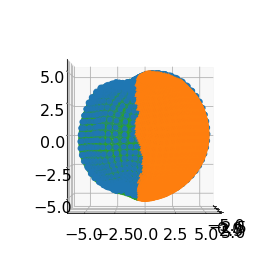

In [10]:
print('Visualize the nodes in 3D...')
fig, ax = visSH3d(umesh1, cmesh=tmesh1, r0=r0, show=False, elevation=0, azimuth=0, surface=False, figsize=(4,4))
nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
plt.tight_layout(); plt.savefig(savename+'_compare.png', transparent=True)
plt.show()

Visualize the nodes in 3D...


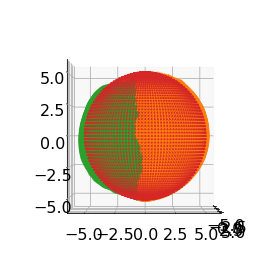

In [11]:
print('Visualize the nodes in 3D...')
fig, ax = visSH3d(umesh1*0, cmesh=tmesh1, r0=1, show=False, elevation=0, azimuth=0, surface=False, figsize=(4,4))
nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
ax.scatter3D(X0[..., 0].flatten()*r0, X0[..., 1].flatten()*r0, X0[..., 2].flatten()*r0, marker='^', s=1)
plt.tight_layout(); plt.savefig(savename+'_ur3d.png', transparent=True)
plt.show()

Visualize the nodes in 3D...


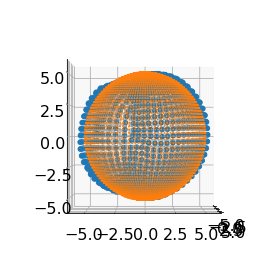

In [12]:
print('Visualize the nodes in 3D...')
fig, ax = visSH3d(umesh1, cmesh=tmesh1, r0=r0, show=False, elevation=0, azimuth=0, surface=False, figsize=(4,4))
ax.scatter3D(X0[..., 0].flatten()*r0, X0[..., 1].flatten()*r0, X0[..., 2].flatten()*r0, marker='^', s=1)
plt.tight_layout(); plt.savefig(savename+'_ut3d.png', transparent=True)
plt.show()

Visualize the shape in 3D...


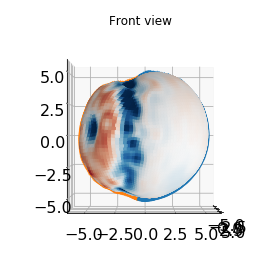

In [13]:
print('Visualize the shape in 3D...')
fig, ax = visSH3d(umesh1_fine, cmesh=tmesh1_fine, 
                  r0=r0, show=False, 
                  elevation=0, azimuth=0, 
                  surface=True, figsize=(4,4))

# reference data
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
ax.set_title('Front view')
plt.tight_layout(); plt.savefig(savename+'_front.png', transparent=True)
plt.show()

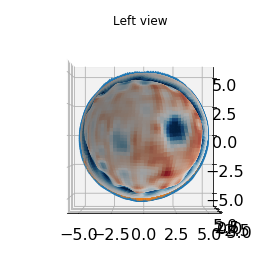

In [14]:
fig, ax = visSH3d(umesh1_fine, cmesh=tmesh1_fine, 
                  r0=r0, show=False, 
                  elevation=0, azimuth=-90, 
                  surface=True, figsize=(4,4))

# Plot reference data
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
ax.set_title('Left view')
plt.tight_layout(); plt.savefig(savename+'_left.png', transparent=True)
plt.show()

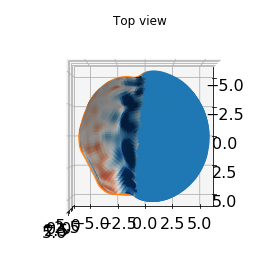

In [15]:
fig, ax = visSH3d(umesh1_fine, cmesh=tmesh1_fine, 
                  r0=r0, show=False, 
                  elevation=90, azimuth=0, 
                  surface=True, figsize=(4,4))

# Plot reference data
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
plt.tight_layout(); plt.savefig(savename+'_top.png', transparent=True)
ax.set_title('Top view')
plt.show()